# mTSP: Multiple Traveling Salesman Problem

### Descripción del problema

El Problema de Varios Viajeros (mTSP, por sus siglas en inglés "Multiple Traveling Salesman Problem") es una extensión del clásico Problema del Viajante de Comercio (TSP, por sus siglas en inglés), donde en lugar de un solo viajante que debe visitar todas las ciudades, hay varios viajantes (o vehículos) que deben distribuirse las ciudades de forma eficiente, minimizando la distancia total recorrida por todos ellos.

### Contexto y Aplicación:
Este problema tiene numerosas aplicaciones prácticas en áreas como:

Distribución de mercancías: Donde varios vehículos deben entregar productos a diferentes ubicaciones.
Logística de flotas de vehículos: Empresas de transporte o entrega que deben planificar rutas eficientes para múltiples vehículos.
Servicios de mensajería y paquetería: Donde varios repartidores deben cubrir una serie de direcciones de entrega.
Rutas de recolección de residuos: Donde varias rutas de camiones deben ser asignadas para la recolección de basura en una ciudad o área determinada.
### Enunciado del Problema:
Dado un conjunto de ciudades o puntos de interés (incluido un depósito inicial) y un número 
𝑚 de viajeros (o vehículos), el objetivo es encontrar un conjunto de rutas (una por cada viajero) que permita que cada ciudad sea visitada exactamente una vez, de manera que:

Cada vehículo comienza y termina en el depósito.
La distancia total recorrida por todos los vehículos sea mínima.
Los vehículos no se cruzan entre sí ni visitan las mismas ciudades.
Cada vehículo cubre un conjunto de ciudades, distribuyendo el trabajo de manera eficiente.

In [70]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

#### Se utilizará un dataset artificial que consta de 13 nodos de destino y un nodo de origen

In [71]:
data = pd.read_csv('vrp_instance.csv', sep = ';')

In [72]:
data

,ciudad,x,y,tipo
0,a,7,15,destino
1,b,10,1,destino
2,c,13,10,destino
3,d,3,7,destino
4,e,7,1,destino
5,f,14,3,destino
6,g,5,4,destino
7,h,10,11,destino
8,i,7,11,destino
9,j,12,1,destino


In [73]:
# ciudades a las que se debe visitar
cities = list(data["ciudad"])

In [74]:
# supongamos que se tienen 3 vehiculos
vehicles = ["V1","V2","V3"]

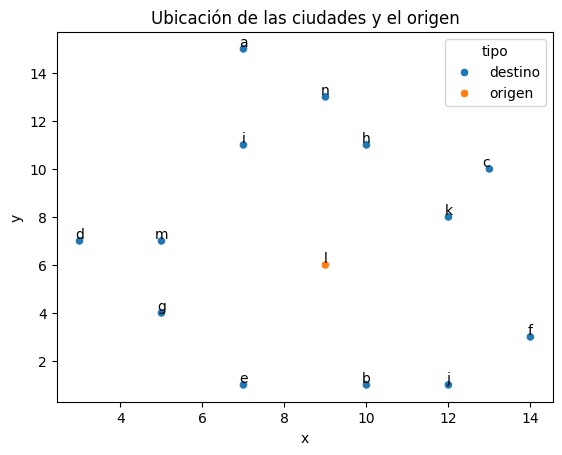

In [75]:
fig, ax = plt.subplots()
plt.title("Ubicación de las ciudades y el origen")
sns.scatterplot(data = data, x = 'x', y ='y', hue='tipo')
for i in range(len(data)):
    ax.text(data["x"][i], data["y"][i], data['ciudad'][i], fontsize=10, ha='center', va = 'bottom')

### Cálculo de la distancia euclidiana

In [76]:
# distancia a la ciudad j desde la ciudad i, notar que Cij == Cji (TSP simétrico)
distances = {}
for i in cities:
    for j in cities:
        if i!=j:
            x1 = data.loc[data["ciudad"] == i, "x"].values[0]
            y1 = data.loc[data["ciudad"] == i, "y"].values[0]
            x2 = data.loc[data["ciudad"] == j, "x"].values[0]
            y2 = data.loc[data["ciudad"] == j, "y"].values[0]
            distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) 
        else:
            distance = 0
        distances[(i,j)] = distance
        distances[(j,i)] = distance

### Formulación del problema de optimización

In [77]:
def get_problem(costos, n, origen):
    # Definir el modelo
    model = pulp.LpProblem("mTSP", pulp.LpMinimize)
    
    # Variables de decisión: x[i,j,k] = 1 si el vendedor k viaja de i a j
    x = pulp.LpVariable.dicts("x", ((k, i, j) for k in vehicles for i in cities for j in cities if i != j), cat='Binary')
    
    # Variables auxiliares: u[i,k] es el número de visita de la ciudad i por el vendedor k
    u = pulp.LpVariable.dicts("u", ((k,i) for k in vehicles for i in cities), lowBound=1, upBound=n, cat='Integer')
    
    # Función objetivo: minimizar la distancia total recorrida
    model += pulp.lpSum(costos[(i, j)] * x[(k, i, j)] for k in vehicles for i in cities for j in cities if i != j)
    
    # Restricciones
    
    # 1. No se puede viajar a la misma ciudad
    
    # 2. Cada vendedor tiene que salir del depósito (ciudad l)
    for k in vehicles:
        model += pulp.lpSum(x[(k,origen,j)] for j in cities if j!= origen) == 1
    
    # 3. Cada vendedor tiene que regresar al depósito
    for k in vehicles:
        model += pulp.lpSum(x[(k,i,origen)] for i in cities if i!=origen) == 1
    
    # 4. Un vendedor que llega a una ciudad debe salir de ella
    for i in cities:
        for k in vehicles:
            if i != origen:
                model += pulp.lpSum(x[(k,j,i)] for j in cities if i!=j) == pulp.lpSum(x[(k,i,j)] for j in cities if i!=j)
    
    # 5. Cada ciudad debe ser salida por exactamente un vendedor
    for i in cities:
        if i!= origen:
            model += pulp.lpSum(x[(k,i,j)] for j in cities for k in vehicles if i!= j) == 1
    
    # 6. Cada ciudad debe ser llegada por exactamente un vendedor
    for j in cities:
        if j != origen:
            model += pulp.lpSum(x[(k,i,j)] for i in cities for k in vehicles if i!=j) == 1
    
    # 7. Eliminación de sub-rutas (restricción MTZ)
    for k in vehicles:
        for i in cities:
            for j in cities:
                if i != j:
                    if i!= origen:
                        if j != origen:
                            model += u[(k,i)] - u[(k,j)] + n * x[(k,i,j)] <= n - 1
    return model, x

### Solución del problema

In [78]:
# como l es el origen, lo remuevo
origen = 'l'

In [79]:
problema, x = get_problem(distances, len(cities), origen) # resto 1 ya que no considera el origen

In [80]:
problema.solve(pulp.PULP_CBC_CMD(msg=True))

1

#### Distancia Optima

In [81]:
# Imprimir resultados
print(f"Estado: {pulp.LpStatus[problema.status]}")
print(f"Distancia óptima a recorrer por el vendedor: {pulp.value(problema.objective)} unidades de longitud")

Estado: Optimal
Distancia óptima a recorrer por el vendedor: 56.698893505319866 unidades de longitud


### Ruta Optima

In [82]:
for k in vehicles:
    for i in cities:
        for j in cities:
                if i!=j:
                    if 0 < x[(k,i, j)].varValue :
                        print(f"Camino optimo: desde la ciudad  {i} a la ciudad  {j} y la recorre el vehiculo  {k}")

Camino optimo: desde la ciudad  b a la ciudad  e y la recorre el vehiculo  V1
Camino optimo: desde la ciudad  e a la ciudad  l y la recorre el vehiculo  V1
Camino optimo: desde la ciudad  f a la ciudad  j y la recorre el vehiculo  V1
Camino optimo: desde la ciudad  j a la ciudad  b y la recorre el vehiculo  V1
Camino optimo: desde la ciudad  l a la ciudad  f y la recorre el vehiculo  V1
Camino optimo: desde la ciudad  a a la ciudad  i y la recorre el vehiculo  V2
Camino optimo: desde la ciudad  c  a la ciudad  h y la recorre el vehiculo  V2
Camino optimo: desde la ciudad  h a la ciudad  n y la recorre el vehiculo  V2
Camino optimo: desde la ciudad  i a la ciudad  l y la recorre el vehiculo  V2
Camino optimo: desde la ciudad  k a la ciudad  c  y la recorre el vehiculo  V2
Camino optimo: desde la ciudad  l a la ciudad  k y la recorre el vehiculo  V2
Camino optimo: desde la ciudad  n a la ciudad  a y la recorre el vehiculo  V2
Camino optimo: desde la ciudad  d a la ciudad  m y la recorre 

In [83]:
ruta_1 = [origen]
ruta_2 = [origen]
ruta_3 = [origen]
def encontrar_siguiente(ruta,vehiculo, inicio):
    for j in cities:
        if j != origen:
            if j!= inicio:
                if 0 < x[(vehiculo,inicio, j)].varValue : 
                    ruta.append(j)
    return ruta

In [84]:
def encontrar_ruta(ruta, vehiculo):
    largo_actual = 0
    largo_nuevo = 1
    while largo_actual  < largo_nuevo:
        largo_actual = len(ruta)
        ruta_1 = encontrar_siguiente(ruta,vehiculo, ruta[-1])
        largo_nuevo = len(ruta)
    ruta.append(ruta[0])
    return ruta

In [85]:
ruta_1 = encontrar_ruta(ruta_1, 'V1')
ruta_2 = encontrar_ruta(ruta_2, 'V2')
ruta_3 = encontrar_ruta(ruta_3, 'V3')

In [86]:
ruta_1,ruta_2, ruta_3

(['l', 'f', 'j', 'b', 'e', 'l'],
 ['l', 'k', 'c ', 'h', 'n', 'a', 'i', 'l'],
 ['l', 'g', 'd', 'm', 'l'])

In [87]:
orden1 = pd.DataFrame({"ciudad":ruta_1,"orden": [i for i in range(len(ruta_1))], 'vehiculo':['V1' for i in range(len(ruta_1))]})
orden2 = pd.DataFrame({"ciudad":ruta_2,"orden": [i for i in range(len(ruta_2))], 'vehiculo':['V2' for i in range(len(ruta_2))]})
orden3 = pd.DataFrame({"ciudad":ruta_3,"orden": [i for i in range(len(ruta_3))], 'vehiculo':['V3' for i in range(len(ruta_3))]})

In [88]:
orden = pd.concat([orden1,orden2, orden3])

In [89]:
orden

,ciudad,orden,vehiculo
0,l,0,V1
1,f,1,V1
2,j,2,V1
3,b,3,V1
4,e,4,V1
5,l,5,V1
0,l,0,V2
1,k,1,V2
2,c,2,V2
3,h,3,V2


In [90]:
data = data.merge(orden, how = 'inner', on = 'ciudad')
data = data.sort_values(by = 'orden')

In [91]:
data

,ciudad,x,y,tipo,orden,vehiculo
15,l,9,6,origen,0,V3
11,l,9,6,origen,0,V1
13,l,9,6,origen,0,V2
5,f,14,3,destino,1,V1
6,g,5,4,destino,1,V3
10,k,12,8,destino,1,V2
9,j,12,1,destino,2,V1
2,c,13,10,destino,2,V2
3,d,3,7,destino,2,V3
1,b,10,1,destino,3,V1


### Visualización Ruta Optima

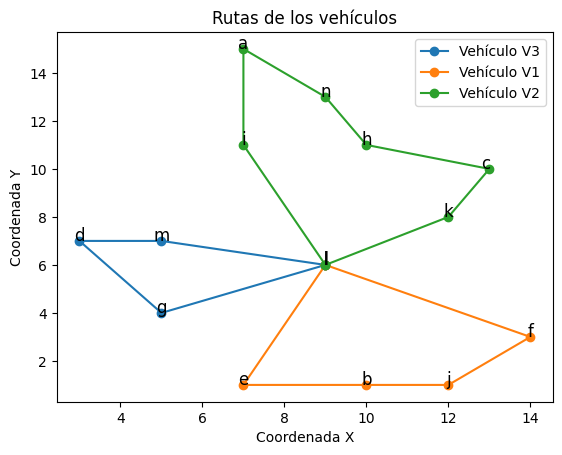

In [92]:
import matplotlib.pyplot as plt

# Suponiendo que 'data' es un DataFrame que contiene columnas: 'vehiculo', 'x', 'y', 'ciudad'

# Lista de colores predefinidos
colores = ['orange','lightgreen', 'purple']

# Crear la figura y el eje
fig, ax = plt.subplots()

# Iterar sobre cada vehículo único
for idx, vehiculo in enumerate(data["vehiculo"].unique()):
    # Filtrar el DataFrame para obtener solo los datos de este vehículo
    df = data[data["vehiculo"] == vehiculo]
    
    # Asignar un color a cada vehículo según su índice
    color = colores[idx % len(colores)]  # Si hay más vehículos que colores, se repiten
    
    # Graficar la trayectoria del vehículo
    ax.plot(df["x"], df["y"], '-o', label=f'Vehículo {vehiculo}')
    
    # Añadir etiquetas con los nombres de las ciudades
    for i in range(len(df)):
        ax.text(df["x"].iloc[i], df["y"].iloc[i], df['ciudad'].iloc[i], fontsize=12, ha='center', color='black')

# Ajustar el gráfico
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')
ax.set_title('Rutas de los vehículos')
ax.legend()

# Mostrar el gráfico
plt.show()


__Nota__: Al terminar de visitar la ultima ciudad retorna al punto inicial a.

### Crear gif animado

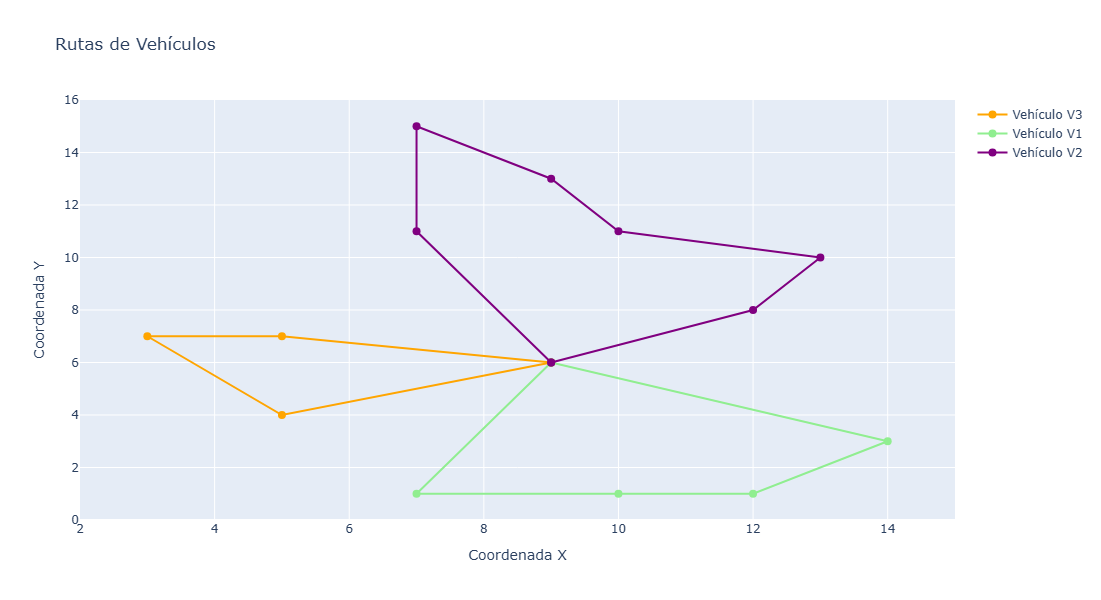

GIF guardado como 'animacion_rutas.gif'.


In [161]:
import plotly.graph_objects as go
import imageio
import os

# Lista de colores para los vehículos
colores = ['orange', 'lightgreen', 'purple']

# Crear la figura inicial
fig = go.Figure()

# Crear los frames para la animación
frames = []
image_files = []

# Suponiendo que 'data' tiene las columnas: 'vehiculo', 'x', 'y', 'ciudad'
# Y 'vehiculo' es una columna que indica qué vehículo realiza la ruta

# Crear los frames para la animación
for i in range(1, len(data) + 1):  # Crear un frame por cada ciudad
    # Limpiar las trazas previas
    fig.data = []

    # Añadir la ruta de cada vehículo hasta el punto i
    for idx, vehiculo in enumerate(data['vehiculo'].unique()):
        df = data[data['vehiculo'] == vehiculo].iloc[:i]  # Tomar solo los primeros i puntos
        
        color = colores[idx % len(colores)]  # Asignar color a cada vehículo
        
        # Crear una traza para cada vehículo
        fig.add_trace(go.Scatter(
            x=df['x'], y=df['y'], mode='lines+markers', line=dict(color=color, width=2),
            marker=dict(color=color, size=8),
            name=f'Vehículo {vehiculo}'
        ))

    # Configurar el layout
    fig.update_layout(
        title='Rutas de Vehículos',
        xaxis_title='Coordenada X',
        yaxis_title='Coordenada Y',
        width=600,
        height=600,
        xaxis=dict(range=[data['x'].min() - 1, data['x'].max() + 1]),  # Ajuste dinámico de rango X
        yaxis=dict(range=[data['y'].min() - 1, data['y'].max() + 1]),  # Ajuste dinámico de rango Y
        showlegend=True,
        updatemenus=[],  # Desactivar botones y controles
        sliders=[]      # Desactivar sliders
    )
    
    # Guardar la figura como imagen
    img_path = f'frame_{i}.png'
    fig.write_image(img_path)
    image_files.append(img_path)

fig.show()

# Crear el GIF
with imageio.get_writer('animacion_rutas.gif', mode='I', duration=1000) as writer:
    for image_file in image_files:
        writer.append_data(imageio.imread(image_file))  # Añadir cada imagen como un frame

# Limpiar imágenes temporales
for image_file in image_files:
    os.remove(image_file)

print("GIF guardado como 'animacion_rutas.gif'.")
